# Experiment: RA-DRL Phase B Approximate Reproduction

## Objective
- Phase Aレビュー仕様に基づき、RA-DRLを手元データ（`sector_returns` + `macro` + `SPX`）で近似再現する。
- 3基底PPO（Log/DSR/MDD）+ CNN融合（RA）+ ベンチマーク（1/n, MVO, SPX）を同一条件で比較する。

## Scope Difference vs Paper
- 論文の4市場30銘柄OHLCは未使用。代わりに9セクターETFリターンから擬似価格を再構成して特徴量を作成。
- DSRはMoody系の標準式を採用し、論文PDF抽出の曖昧記号は本Notebookでは標準形で固定。
- 本Notebookは「近似再現」であり、厳密再現は将来のデータ拡張で実施する。


In [1]:
# Setup: imports and reproducibility
from __future__ import annotations

import math
import random
import warnings
from dataclasses import dataclass
from typing import Callable

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium import spaces
from scipy.optimize import minimize
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

SEED


42

## Plan

- Hypothesis:
  - 3報酬の基底PPO行動をCNN融合したRA戦略は、単独報酬戦略より安定したリスク調整後成績を示す。
- Variables to sweep:
  - `mode` (`quick` / `full`), `ppo_timesteps`, `fusion_epochs`, `c_value`。
- Metrics to record:
  - CR, AR, SR, CAR, SOR, OR, AV, Stability。


In [2]:
# Configuration
@dataclass
class RunConfig:
    mode: str = 'full'
    seed: int = 42
    train_start: str = '2011-01-01'
    train_end: str = '2020-12-31'
    test_start: str = '2021-01-01'
    test_end: str = '2024-03-31'
    cost_bps: float = 5.0
    cov_window: int = 60
    indicator_windows: dict = None
    ppo_timesteps: int = 50_000
    fusion_epochs: int = 20
    c_value: float = 3.0

    def __post_init__(self):
        if self.indicator_windows is None:
            self.indicator_windows = {
                'sma_fast': 30,
                'sma_slow': 60,
                'macd_fast': 12,
                'macd_slow': 26,
                'macd_signal': 9,
                'bb_window': 20,
                'rsi_window': 14,
                'cci_window': 20,
                'adx_window': 14,
            }


def make_config(mode: str = 'quick') -> RunConfig:
    if mode == 'quick':
        return RunConfig(mode='quick', ppo_timesteps=50_000, fusion_epochs=20, cov_window=60, c_value=3.0)
    if mode == 'full':
        return RunConfig(mode='full', ppo_timesteps=300_000, fusion_epochs=80, cov_window=60, c_value=3.0)
    raise ValueError("mode must be 'quick' or 'full'")


config = make_config('quick')
config


RunConfig(mode='quick', seed=42, train_start='2011-01-01', train_end='2020-12-31', test_start='2021-01-01', test_end='2024-03-31', cost_bps=5.0, cov_window=60, indicator_windows={'sma_fast': 30, 'sma_slow': 60, 'macd_fast': 12, 'macd_slow': 26, 'macd_signal': 9, 'bb_window': 20, 'rsi_window': 14, 'cci_window': 20, 'adx_window': 14}, ppo_timesteps=50000, fusion_epochs=20, c_value=3.0)

In [3]:
# Data loading and alignment interface

def load_and_align_data(
    sector_path: str = 'data/sector_returns.csv',
    macro_path: str = 'data/macro.csv',
    spx_path: str = 'data/SPX.csv',
) -> dict[str, pd.DataFrame]:
    sector = pd.read_csv(sector_path, parse_dates=['Date']).sort_values('Date').set_index('Date')
    macro = pd.read_csv(macro_path, parse_dates=['Date']).sort_values('Date').set_index('Date')
    spx = pd.read_csv(spx_path, parse_dates=['Date']).sort_values('Date').set_index('Date')

    # Macro: forward fill then drop leading NaN rows to satisfy no-NaN requirement.
    macro = macro.ffill().dropna()

    common_idx = sector.index.intersection(macro.index).intersection(spx.index)
    common_idx = common_idx.sort_values()

    sector = sector.loc[common_idx]
    macro = macro.loc[common_idx]
    spx = spx.loc[common_idx]

    merged = pd.concat([sector, macro, spx], axis=1)

    assert merged.index.is_monotonic_increasing, 'Date index must be sorted'
    assert not merged.index.duplicated().any(), 'No duplicated dates allowed'

    return {
        'sector_returns': sector,
        'macro': macro,
        'spx': spx,
        'merged': merged,
    }


data_dict = load_and_align_data()
{k: v.shape for k, v in data_dict.items()}


{'sector_returns': (6321, 9),
 'macro': (6321, 3),
 'spx': (6321, 1),
 'merged': (6321, 13)}

In [4]:
# Proxy price construction interface

def build_proxy_prices(returns_df: pd.DataFrame, base: float = 100.0) -> pd.DataFrame:
    clipped = returns_df.clip(lower=-0.95, upper=0.95)
    prices = base * (1.0 + clipped).cumprod()
    return prices


proxy_prices = build_proxy_prices(data_dict['sector_returns'])
proxy_prices.head()


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2001-01-03,100.595277,96.946887,105.395084,104.343238,116.101672,95.399110,97.896704,107.890124,107.889793
2001-01-04,103.943563,93.940815,103.542205,105.180504,117.266926,91.629718,96.367079,111.058034,109.418879
2001-01-05,101.785738,95.960488,101.362352,102.145449,110.169514,92.239448,95.411117,108.069398,105.810323
2001-01-08,102.083369,95.631714,100.326940,101.308183,109.851718,92.849196,96.845081,106.515342,104.403595
2001-01-09,97.916717,93.705928,98.637642,101.622182,112.288140,93.847056,97.275329,107.830316,103.547342


In [5]:
# Technical indicator helpers (numpy/pandas only)

def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False, min_periods=span).mean()


def rsi(close: pd.Series, window: int = 14) -> pd.Series:
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    roll_down = down.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100 / (1 + rs))


def cci_from_close(close: pd.Series, window: int = 20) -> pd.Series:
    # Typical price approximation: TP ~= close (OHLC unavailable in proxy data).
    tp = close
    sma_tp = tp.rolling(window).mean()
    mad = (tp - sma_tp).abs().rolling(window).mean()
    return (tp - sma_tp) / (0.015 * (mad + 1e-12))


def adx_from_proxy_close(close: pd.Series, window: int = 14) -> pd.Series:
    # Proxy OHLC from close + return magnitude to avoid external dependencies.
    ret = close.pct_change().fillna(0.0)
    high = close * (1.0 + 0.5 * ret.abs())
    low = close * (1.0 - 0.5 * ret.abs())

    up_move = high.diff()
    down_move = -low.diff()

    plus_dm = pd.Series(np.where((up_move > down_move) & (up_move > 0), up_move, 0.0), index=close.index)
    minus_dm = pd.Series(np.where((down_move > up_move) & (down_move > 0), down_move, 0.0), index=close.index)

    tr1 = (high - low).abs()
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    plus_di = 100 * plus_dm.ewm(alpha=1/window, adjust=False, min_periods=window).mean() / (atr + 1e-12)
    minus_di = 100 * minus_dm.ewm(alpha=1/window, adjust=False, min_periods=window).mean() / (atr + 1e-12)

    dx = (100 * (plus_di - minus_di).abs() / (plus_di + minus_di + 1e-12)).fillna(0.0)
    adx = dx.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    return adx


In [6]:
# Feature construction interface

def build_features(
    prices_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    cov_window: int,
    indicator_windows: dict,
) -> pd.DataFrame:
    assets = list(returns_df.columns)
    idx = returns_df.index

    # Rolling covariance features (flattened n x n matrix).
    cov_frames = []
    for t in range(len(idx)):
        if t < cov_window - 1:
            cov_flat = np.full(len(assets) * len(assets), np.nan)
        else:
            window_ret = returns_df.iloc[t - cov_window + 1 : t + 1]
            cov = window_ret.cov().values.astype(float)
            cov_flat = cov.reshape(-1)
        cov_frames.append(cov_flat)

    cov_cols = [f'cov_{i}_{j}' for i in assets for j in assets]
    cov_df = pd.DataFrame(cov_frames, index=idx, columns=cov_cols)

    tech_frames = []
    for asset in assets:
        close = prices_df[asset]
        w = indicator_windows

        sma30 = close.rolling(w['sma_fast']).mean()
        sma60 = close.rolling(w['sma_slow']).mean()
        macd_line = ema(close, w['macd_fast']) - ema(close, w['macd_slow'])
        bb_mid = close.rolling(w['bb_window']).mean()
        bb_std = close.rolling(w['bb_window']).std()
        bb_up = bb_mid + 2.0 * bb_std
        bb_low = bb_mid - 2.0 * bb_std
        rsi14 = rsi(close, w['rsi_window'])
        cci20 = cci_from_close(close, w['cci_window'])
        adx14 = adx_from_proxy_close(close, w['adx_window'])

        tech = pd.DataFrame({
            f'{asset}_sma30': sma30,
            f'{asset}_sma60': sma60,
            f'{asset}_macd': macd_line,
            f'{asset}_bb_up': bb_up,
            f'{asset}_bb_low': bb_low,
            f'{asset}_rsi': rsi14,
            f'{asset}_cci': cci20,
            f'{asset}_adx': adx14,
        }, index=idx)
        tech_frames.append(tech)

    tech_df = pd.concat(tech_frames, axis=1)

    macro_features = macro_df.copy()
    macro_features.columns = [f'macro_{c}' for c in macro_features.columns]

    raw_returns = returns_df.add_prefix('ret_')

    feat = pd.concat([cov_df, tech_df, macro_features, raw_returns], axis=1)

    # Leak prevention: only use information available up to t for decision at t.
    feat = feat.shift(1)

    feat = feat.dropna().astype(np.float32)
    return feat


features = build_features(
    proxy_prices,
    data_dict['sector_returns'],
    data_dict['macro'],
    cov_window=config.cov_window,
    indicator_windows=config.indicator_windows,
)

features.shape


(6261, 165)

In [7]:
# Train/test split and core tensors

def split_data_by_config(
    features_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    spx_df: pd.DataFrame,
    config: RunConfig,
) -> dict[str, pd.DataFrame]:
    common = features_df.index.intersection(returns_df.index).intersection(spx_df.index)
    common = common.sort_values()

    feat = features_df.loc[common]
    ret = returns_df.loc[common]
    spx = spx_df.loc[common]

    train_mask = (feat.index >= config.train_start) & (feat.index <= config.train_end)
    test_mask = (feat.index >= config.test_start) & (feat.index <= config.test_end)

    train_feat = feat.loc[train_mask]
    test_feat = feat.loc[test_mask]
    train_ret = ret.loc[train_mask]
    test_ret = ret.loc[test_mask]
    train_spx = spx.loc[train_mask]
    test_spx = spx.loc[test_mask]

    assert len(train_feat) > 0, 'Train split must be non-empty'
    assert len(test_feat) > 0, 'Test split must be non-empty'

    return {
        'train_feat': train_feat,
        'test_feat': test_feat,
        'train_ret': train_ret,
        'test_ret': test_ret,
        'train_spx': train_spx,
        'test_spx': test_spx,
    }


split = split_data_by_config(features, data_dict['sector_returns'], data_dict['spx'], config)
{key: value.shape for key, value in split.items()}


{'train_feat': (2517, 165),
 'test_feat': (814, 165),
 'train_ret': (2517, 9),
 'test_ret': (814, 9),
 'train_spx': (2517, 1),
 'test_spx': (814, 1)}

In [8]:
# Reward functions and utility

def softmax_weights(action: np.ndarray) -> np.ndarray:
    a = np.asarray(action, dtype=np.float64)
    a = a - np.max(a)
    e = np.exp(a)
    s = e / (e.sum() + 1e-12)
    return s.astype(np.float32)


def reward_log(port_ret: float) -> float:
    return float(np.log1p(np.clip(port_ret, -0.999, None)))


def reward_dsr(port_ret: float, state: dict, eta: float = 1/252) -> float:
    x_prev = state.get('x', 0.0)
    y_prev = state.get('y', 0.0)

    dx = port_ret - x_prev
    dy = (port_ret ** 2) - y_prev

    denom = (y_prev - x_prev ** 2)
    denom = max(denom, 1e-12) ** 1.5

    dsr = (y_prev * dx - 0.5 * x_prev * dy) / denom

    state['x'] = x_prev + eta * dx
    state['y'] = y_prev + eta * dy

    if not np.isfinite(dsr):
        return 0.0
    return float(np.clip(dsr, -10.0, 10.0))


def reward_mdd(port_ret: float, state: dict) -> float:
    wealth = state.get('wealth', 1.0)
    peak = state.get('peak', 1.0)

    wealth = wealth * (1.0 + port_ret)
    peak = max(peak, wealth)

    dd = (peak - wealth) / (peak + 1e-12)

    state['wealth'] = wealth
    state['peak'] = peak

    return float(-dd)


In [9]:
# Portfolio environment interface
class PortfolioEnv(gym.Env):
    metadata = {'render_modes': []}

    def __init__(
        self,
        features_df: pd.DataFrame,
        returns_df: pd.DataFrame,
        reward_type: str,
        cost_bps: float,
        seed: int = 42,
    ):
        super().__init__()
        self.features = features_df.values.astype(np.float32)
        self.returns = returns_df.loc[features_df.index].values.astype(np.float32)
        self.reward_type = reward_type
        self.cost_rate = cost_bps / 10000.0
        self.seed_value = seed

        self.n_steps = self.features.shape[0]
        self.n_assets = self.returns.shape[1]
        self.n_features = self.features.shape[1]

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.n_features,),
            dtype=np.float32,
        )
        self.action_space = spaces.Box(
            low=-5.0,
            high=5.0,
            shape=(self.n_assets,),
            dtype=np.float32,
        )

        self._rng = np.random.default_rng(seed)
        self.reset(seed=seed)

    def _get_obs(self) -> np.ndarray:
        return self.features[self.t]

    def _compute_reward(self, port_ret: float) -> float:
        if self.reward_type == 'log':
            return reward_log(port_ret)
        if self.reward_type == 'dsr':
            return reward_dsr(port_ret, self.reward_state)
        if self.reward_type == 'mdd':
            return reward_mdd(port_ret, self.reward_state)
        raise ValueError(f'Unknown reward_type: {self.reward_type}')

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)

        self.t = 0
        self.prev_w = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
        self.reward_state = {'x': 0.0, 'y': 0.0, 'wealth': 1.0, 'peak': 1.0}

        obs = self._get_obs()
        info = {'weights': self.prev_w.copy(), 'portfolio_return': 0.0}
        return obs, info

    def step(self, action):
        w = softmax_weights(action)

        # Apply action decided at t to return at t+1 to avoid look-ahead.
        if self.t + 1 < self.n_steps:
            next_ret_vec = self.returns[self.t + 1]
        else:
            next_ret_vec = np.zeros(self.n_assets, dtype=np.float32)

        turnover = float(np.abs(w - self.prev_w).sum())
        trading_cost = self.cost_rate * turnover
        gross_ret = float(np.dot(w, next_ret_vec))
        net_ret = gross_ret - trading_cost

        reward = self._compute_reward(net_ret)

        self.prev_w = w.copy()
        self.t += 1

        terminated = self.t >= (self.n_steps - 2)
        truncated = False

        obs = self._get_obs() if not terminated else self.features[min(self.t, self.n_steps - 1)]
        info = {
            'weights': w.copy(),
            'portfolio_return': net_ret,
            'gross_return': gross_ret,
            'trading_cost': trading_cost,
        }
        return obs, reward, terminated, truncated, info


In [10]:
# Sanity checks for split, leak prevention, and NaN
assert split['train_feat'].isna().sum().sum() == 0
assert split['test_feat'].isna().sum().sum() == 0

common_idx = split['train_feat'].index.intersection(split['train_ret'].index)
assert len(common_idx) == len(split['train_feat'])

# Leak prevention check: feature at date d is based on historical info up to d-1 due to shift(1).
leak_probe_date = split['train_feat'].index[0]
assert leak_probe_date > pd.Timestamp(config.train_start)

print('Sanity checks passed.')


Sanity checks passed.


In [11]:
# PPO training interface

def train_ppo_agent(
    features_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    config: RunConfig,
    reward_type: str,
) -> PPO:
    def make_env():
        return PortfolioEnv(
            features_df=features_df,
            returns_df=returns_df,
            reward_type=reward_type,
            cost_bps=config.cost_bps,
            seed=config.seed,
        )

    vec_env = DummyVecEnv([make_env])

    policy_kwargs = dict(net_arch=[128, 128])
    model = PPO(
        'MlpPolicy',
        vec_env,
        seed=config.seed,
        verbose=0,
        learning_rate=3e-4,
        n_steps=256,
        batch_size=128,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        policy_kwargs=policy_kwargs,
    )
    model.learn(total_timesteps=config.ppo_timesteps)
    return model


def rollout_agent_weights(
    model: PPO,
    features_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    config: RunConfig,
    reward_type: str,
) -> tuple[np.ndarray, np.ndarray]:
    env = PortfolioEnv(
        features_df=features_df,
        returns_df=returns_df,
        reward_type=reward_type,
        cost_bps=config.cost_bps,
        seed=config.seed,
    )

    obs, _ = env.reset(seed=config.seed)
    done = False
    weights = []
    net_returns = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, term, trunc, info = env.step(action)
        done = bool(term or trunc)
        weights.append(info['weights'])
        net_returns.append(info['portfolio_return'])

    weights_arr = np.asarray(weights, dtype=np.float32)
    returns_arr = np.asarray(net_returns, dtype=np.float32)

    # Constraint checks
    assert np.all(np.isfinite(weights_arr))
    assert np.all(np.abs(weights_arr.sum(axis=1) - 1.0) < 1e-6)
    assert np.min(weights_arr) >= -1e-7

    return weights_arr, returns_arr


In [12]:
# Train base PPO agents (Log / DSR / MDD)
base_agents = {}
for rt in ['log', 'dsr', 'mdd']:
    print(f'Training {rt} agent ...')
    base_agents[rt] = train_ppo_agent(split['train_feat'], split['train_ret'], config, rt)

print('Base agent training done.')


Training log agent ...
Training dsr agent ...
Training mdd agent ...
Base agent training done.


In [13]:
# Rollout base agents on train/test
base_train = {}
base_test = {}
for rt, model in base_agents.items():
    w_tr, r_tr = rollout_agent_weights(model, split['train_feat'], split['train_ret'], config, rt)
    w_te, r_te = rollout_agent_weights(model, split['test_feat'], split['test_ret'], config, rt)
    base_train[rt] = {'weights': w_tr, 'returns': r_tr}
    base_test[rt] = {'weights': w_te, 'returns': r_te}

{k: (v['weights'].shape, v['returns'].shape) for k, v in base_test.items()}


{'log': ((812, 9), (812,)),
 'dsr': ((812, 9), (812,)),
 'mdd': ((812, 9), (812,))}

In [14]:
# Fusion model interface

def build_formula_targets(returns_df: pd.DataFrame, c_value: float) -> np.ndarray:
    # Equation (1): w_i,t = exp(c * rho_i,t) / sum exp(c * rho_i,t)
    r = returns_df.values.astype(np.float32)
    z = c_value * r
    z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z)
    w = e / (e.sum(axis=1, keepdims=True) + 1e-12)
    return w.astype(np.float32)


def weight_dynamics_stats(weight_df: pd.DataFrame) -> dict[str, float]:
    arr = weight_df.values.astype(np.float64)
    n_assets = arr.shape[1]
    eq = np.ones(n_assets, dtype=np.float64) / n_assets

    dist_eq = np.abs(arr - eq).sum(axis=1)
    turnover = np.abs(np.diff(arr, axis=0)).sum(axis=1) if len(arr) > 1 else np.array([0.0])
    time_std = arr.std(axis=0)

    return {
        'dist_eq_mean': float(dist_eq.mean()),
        'turnover_mean': float(turnover.mean()),
        'time_std_mean': float(time_std.mean()),
    }


def select_c_value(
    returns_df: pd.DataFrame,
    candidates: tuple[float, ...] = (5.0, 10.0, 20.0, 50.0),
    min_dist_eq: float = 0.06,
    min_turnover: float = 0.08,
) -> tuple[float, pd.DataFrame]:
    rows = []
    selected = None

    for c in candidates:
        target = build_formula_targets(returns_df, c)
        target_df = pd.DataFrame(target, index=returns_df.index, columns=returns_df.columns)
        st = weight_dynamics_stats(target_df)
        passed = (st['dist_eq_mean'] >= min_dist_eq) and (st['turnover_mean'] >= min_turnover)

        rows.append({
            'c_value': float(c),
            'dist_eq_mean': st['dist_eq_mean'],
            'turnover_mean': st['turnover_mean'],
            'time_std_mean': st['time_std_mean'],
            'passed_threshold': bool(passed),
        })

        if selected is None and passed:
            selected = float(c)

    if selected is None:
        selected = float(max(candidates))

    report_df = pd.DataFrame(rows)
    report_df['selected'] = report_df['c_value'].eq(selected)
    return selected, report_df


class GatedBlendNet(nn.Module):
    def __init__(self, n_assets: int):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * n_assets, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # x: [batch, 3, n_assets]
        alpha = torch.softmax(self.gate(x), dim=1)  # [batch, 3]
        w = (alpha.unsqueeze(-1) * x).sum(dim=1)    # convex blend
        w = torch.clamp(w, min=1e-8)
        w = w / w.sum(dim=1, keepdim=True)
        return w, alpha


def train_gated_blend_model(
    actions_train: np.ndarray,
    target_w_train: np.ndarray,
    config: RunConfig,
) -> GatedBlendNet:
    device = torch.device('cpu')
    n_assets = actions_train.shape[-1]
    model = GatedBlendNet(n_assets=n_assets).to(device)

    x = torch.tensor(actions_train, dtype=torch.float32, device=device)
    y = torch.tensor(target_w_train, dtype=torch.float32, device=device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    batch_size = 256

    model.train()
    for epoch in range(config.fusion_epochs):
        perm = torch.randperm(len(x), device=device)
        epoch_loss = 0.0
        n_batches = 0

        for start in range(0, len(x), batch_size):
            idx = perm[start : start + batch_size]
            xb = x[idx]
            yb = y[idx]

            pred_w, pred_alpha = model(xb)
            entropy = -(pred_alpha * torch.log(pred_alpha + 1e-8)).sum(dim=1).mean()
            loss = loss_fn(pred_w, yb) - 1e-3 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += float(loss.item())
            n_batches += 1

        if (epoch + 1) % max(1, config.fusion_epochs // 4) == 0:
            print(f'Epoch {epoch+1:03d}/{config.fusion_epochs} loss={epoch_loss / max(1, n_batches):.6f}')

    return model


def ensure_ra_updates(
    ra_df: pd.DataFrame,
    base_views: dict[str, pd.DataFrame],
    min_ratio: float = 0.25,
) -> tuple[bool, dict[str, float]]:
    ra_stats = weight_dynamics_stats(ra_df)

    base_turnovers = [weight_dynamics_stats(base_views[k])['turnover_mean'] for k in ['Log', 'DSR', 'MDD']]
    median_base_turnover = float(np.median(base_turnovers))
    threshold = float(min_ratio * median_base_turnover)

    passed = bool(ra_stats['turnover_mean'] >= threshold)
    info = {
        'ra_turnover_mean': ra_stats['turnover_mean'],
        'median_base_turnover_mean': median_base_turnover,
        'required_turnover_threshold': threshold,
        'min_ratio': float(min_ratio),
        'passed': passed,
    }
    return passed, info


def fallback_adaptive_blend(
    base_weight_views: dict[str, pd.DataFrame],
    base_return_views: dict[str, pd.Series],
    window: int = 20,
    temp: float = 0.5,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    names = ['Log', 'DSR', 'MDD']

    # Common index for robust alignment
    common_idx = None
    for n in names:
        common_idx = base_weight_views[n].index if common_idx is None else common_idx.intersection(base_weight_views[n].index)
        common_idx = common_idx.intersection(base_return_views[n].index)

    ret_df = pd.concat([base_return_views[n].loc[common_idx] for n in names], axis=1)
    ret_df.columns = names

    rolling_mean = ret_df.rolling(window).mean().shift(1)
    rolling_std = ret_df.rolling(window).std().shift(1)
    sharpe = (rolling_mean / (rolling_std + 1e-8)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    scores = sharpe.values.astype(np.float64) / max(temp, 1e-6)
    scores = scores - scores.max(axis=1, keepdims=True)
    exp_scores = np.exp(scores)
    alpha = exp_scores / (exp_scores.sum(axis=1, keepdims=True) + 1e-12)

    alpha_df = pd.DataFrame(alpha, index=common_idx, columns=['alpha_log', 'alpha_dsr', 'alpha_mdd'])

    w_log = base_weight_views['Log'].loc[common_idx].values
    w_dsr = base_weight_views['DSR'].loc[common_idx].values
    w_mdd = base_weight_views['MDD'].loc[common_idx].values

    w = (
        alpha[:, [0]] * w_log
        + alpha[:, [1]] * w_dsr
        + alpha[:, [2]] * w_mdd
    )
    w = np.clip(w, 1e-8, None)
    w = w / (w.sum(axis=1, keepdims=True) + 1e-12)

    fallback_df = pd.DataFrame(w, index=common_idx, columns=base_weight_views['Log'].columns)
    return fallback_df, alpha_df


In [15]:
# Train fusion model and infer RA weights

def stack_base_actions(base_dict: dict, key: str = 'weights') -> np.ndarray:
    # shape per model: [T, n_assets]
    mats = [base_dict['log'][key], base_dict['dsr'][key], base_dict['mdd'][key]]
    min_len = min(m.shape[0] for m in mats)
    mats = [m[:min_len] for m in mats]
    stacked = np.stack(mats, axis=1)  # [T, 3, n_assets]
    return stacked


train_actions = stack_base_actions(base_train)
test_actions = stack_base_actions(base_test)

train_ret_for_target = split['train_ret'].iloc[:train_actions.shape[0]]
test_ret_for_eval = split['test_ret'].iloc[:test_actions.shape[0]]

selected_c, c_selection_report = select_c_value(
    train_ret_for_target,
    candidates=(5.0, 10.0, 20.0, 50.0),
    min_dist_eq=0.06,
    min_turnover=0.08,
)
config.c_value = float(selected_c)
print('Auto-selected c_value =', config.c_value)
c_selection_report

train_targets = build_formula_targets(train_ret_for_target, config.c_value)

fusion_model = train_gated_blend_model(train_actions, train_targets, config)

with torch.no_grad():
    fusion_model.eval()
    x_test = torch.tensor(test_actions, dtype=torch.float32)
    ra_test_weights_tensor, gate_test_alpha_tensor = fusion_model(x_test)
    ra_test_weights = ra_test_weights_tensor.numpy()
    gate_test_alpha = gate_test_alpha_tensor.numpy()

ra_alpha_plot_df = pd.DataFrame(
    gate_test_alpha,
    index=split['test_ret'].index[1 : 1 + len(gate_test_alpha)],
    columns=['alpha_log', 'alpha_dsr', 'alpha_mdd'],
)

assert np.all(np.abs(ra_test_weights.sum(axis=1) - 1.0) < 1e-6)
assert np.min(ra_test_weights) >= -1e-7

ra_test_weights.shape


Epoch 005/20 loss=0.000012
Epoch 010/20 loss=0.000008
Epoch 015/20 loss=0.000007
Epoch 020/20 loss=0.000007


(812, 9)

In [16]:
# Backtest helpers and benchmarks

def backtest_dynamic_weights(
    weights: np.ndarray,
    returns_df: pd.DataFrame,
    cost_bps: float,
    initial_wealth: float = 1.0,
) -> pd.Series:
    ret = returns_df.values.astype(np.float64)
    n = min(len(weights), len(ret) - 1)
    w = weights[:n]

    prev_w = np.ones(w.shape[1], dtype=np.float64) / w.shape[1]
    wealth = initial_wealth
    out = []

    cost_rate = cost_bps / 10000.0

    for t in range(n):
        wt = w[t]
        rt_next = ret[t + 1]
        turnover = np.abs(wt - prev_w).sum()
        cost = cost_rate * turnover
        day_ret = float(np.dot(wt, rt_next) - cost)
        wealth *= (1.0 + day_ret)
        out.append(day_ret)
        prev_w = wt

    idx = returns_df.index[1 : n + 1]
    return pd.Series(out, index=idx, name='strategy_return')


def backtest_static_weights(
    static_w: np.ndarray,
    returns_df: pd.DataFrame,
    cost_bps: float,
) -> pd.Series:
    weights = np.repeat(static_w.reshape(1, -1), len(returns_df) - 1, axis=0)
    return backtest_dynamic_weights(weights, returns_df, cost_bps=cost_bps)


def mvo_long_only(train_returns: pd.DataFrame) -> np.ndarray:
    mu = train_returns.mean().values.astype(np.float64)
    cov = train_returns.cov().values.astype(np.float64)
    n = len(mu)

    def obj(w):
        p_ret = float(np.dot(w, mu))
        p_vol = float(np.sqrt(np.clip(w @ cov @ w, 1e-12, None)))
        return -(p_ret / p_vol)

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    bnds = [(0.0, 1.0)] * n
    x0 = np.ones(n) / n

    res = minimize(obj, x0, method='SLSQP', bounds=bnds, constraints=cons)
    if not res.success:
        return x0
    return res.x


In [17]:
# Metrics

def safe_div(a: float, b: float) -> float:
    return float(a / b) if abs(b) > 1e-12 else np.nan


def omega_ratio(daily_returns: np.ndarray, threshold: float = 0.0) -> float:
    gains = np.clip(daily_returns - threshold, 0.0, None).sum()
    losses = np.clip(threshold - daily_returns, 0.0, None).sum()
    return safe_div(gains, losses)


def max_drawdown_from_wealth(wealth: np.ndarray) -> float:
    peak = np.maximum.accumulate(wealth)
    dd = (peak - wealth) / (peak + 1e-12)
    return float(np.max(dd))


def stability_r2(daily_returns: np.ndarray) -> float:
    y = np.log1p(np.clip(daily_returns, -0.999, None)).cumsum()
    x = np.arange(len(y), dtype=np.float64)
    if len(y) < 3:
        return np.nan
    coef = np.polyfit(x, y, 1)
    y_hat = coef[0] * x + coef[1]
    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    return float(1.0 - ss_res / (ss_tot + 1e-12))


def compute_metrics(strategy_returns: pd.Series, rf_annual: float = 0.0) -> dict:
    r = strategy_returns.values.astype(np.float64)
    n = len(r)
    rf_daily = rf_annual / 252.0

    wealth = np.cumprod(1.0 + r)
    cr = wealth[-1] - 1.0
    ar = (wealth[-1] ** (252.0 / max(n, 1))) - 1.0

    av = float(np.std(r, ddof=1) * np.sqrt(252)) if n > 1 else np.nan
    sr = safe_div((np.mean(r) - rf_daily), np.std(r, ddof=1))
    if np.isfinite(sr):
        sr *= np.sqrt(252)

    mdd = max_drawdown_from_wealth(wealth)
    car = safe_div(ar - rf_annual, mdd)

    downside = r[r < rf_daily] - rf_daily
    downside_std = float(np.std(downside, ddof=1) * np.sqrt(252)) if len(downside) > 1 else np.nan
    sor = safe_div(ar - rf_annual, downside_std)

    oratio = omega_ratio(r, threshold=rf_daily)
    stab = stability_r2(r)

    return {
        'CR': cr,
        'AR': ar,
        'SR': sr,
        'CAR': car,
        'SOR': sor,
        'OR': oratio,
        'AV': av,
        'Stability': stab,
    }


In [18]:
# Strategy evaluation interface

def evaluate_strategies(
    split: dict[str, pd.DataFrame],
    base_test: dict,
    ra_test_weights: np.ndarray,
    config: RunConfig,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    test_ret = split['test_ret'].iloc[:ra_test_weights.shape[0] + 1]

    # RA and base DRL strategies
    ra_series = backtest_dynamic_weights(ra_test_weights, test_ret, config.cost_bps)
    log_series = backtest_dynamic_weights(base_test['log']['weights'], split['test_ret'], config.cost_bps)
    dsr_series = backtest_dynamic_weights(base_test['dsr']['weights'], split['test_ret'], config.cost_bps)
    mdd_series = backtest_dynamic_weights(base_test['mdd']['weights'], split['test_ret'], config.cost_bps)

    # 1/n benchmark
    n_assets = split['test_ret'].shape[1]
    eq_w = np.ones(n_assets) / n_assets
    eq_series = backtest_static_weights(eq_w, split['test_ret'], config.cost_bps)

    # MVO benchmark
    mvo_w = mvo_long_only(split['train_ret'])
    mvo_series = backtest_static_weights(mvo_w, split['test_ret'], config.cost_bps)

    # SPX benchmark
    spx_close = split['test_spx'].iloc[:, 0]
    spx_daily = spx_close.pct_change().dropna()

    series_map = {
        'RA': ra_series,
        'Log': log_series,
        'DSR': dsr_series,
        'MDD': mdd_series,
        '1/n': eq_series,
        'MVO': mvo_series,
        'SPX': spx_daily,
    }

    # Align to common index for fair comparison.
    common_idx = None
    for s in series_map.values():
        common_idx = s.index if common_idx is None else common_idx.intersection(s.index)

    aligned = {k: v.loc[common_idx] for k, v in series_map.items()}

    metrics = {k: compute_metrics(v) for k, v in aligned.items()}
    metrics_df = pd.DataFrame(metrics).T

    assert set(metrics_df.index.tolist()) == {'RA', 'Log', 'DSR', 'MDD', '1/n', 'MVO', 'SPX'}

    returns_df = pd.DataFrame(aligned)
    return metrics_df, returns_df


metrics_df, strategy_returns_df = evaluate_strategies(split, base_test, ra_test_weights, config)
metrics_df


,CR,AR,SR,CAR,SOR,OR,AV,Stability
RA,0.534566,0.142141,0.939423,0.837644,1.326898,1.172085,0.154152,0.654113
Log,0.504144,0.135065,0.897088,0.756447,1.276871,1.163800,0.154561,0.598449
DSR,0.498084,0.133644,0.909612,0.758200,1.296542,1.164908,0.150352,0.611889
MDD,0.459501,0.124501,0.800357,0.635093,1.143006,1.141774,0.163284,0.361966
1/n,0.536639,0.142619,0.942019,0.841810,1.331467,1.172557,0.154176,0.657233
MVO,0.427825,0.116870,0.723034,0.484634,0.973714,1.130074,0.173779,0.323647
SPX,0.418262,0.114543,0.716648,0.450511,0.955469,1.129623,0.171984,0.111004


In [19]:
# Reproducibility check (optional, quick mode)
RUN_REPRO_CHECK = False
REPRO_SR_DIFF_THRESHOLD = 0.25

if RUN_REPRO_CHECK and config.mode == 'quick':
    cfg = make_config('quick')
    cfg.ppo_timesteps = max(5_000, cfg.ppo_timesteps // 10)

    m1 = train_ppo_agent(split['train_feat'], split['train_ret'], cfg, 'log')
    w1, _ = rollout_agent_weights(m1, split['test_feat'], split['test_ret'], cfg, 'log')
    r1 = backtest_dynamic_weights(w1, split['test_ret'], cfg.cost_bps)

    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)

    m2 = train_ppo_agent(split['train_feat'], split['train_ret'], cfg, 'log')
    w2, _ = rollout_agent_weights(m2, split['test_feat'], split['test_ret'], cfg, 'log')
    r2 = backtest_dynamic_weights(w2, split['test_ret'], cfg.cost_bps)

    sr_diff = abs(compute_metrics(r1)['SR'] - compute_metrics(r2)['SR'])
    print('SR diff:', sr_diff)
    assert sr_diff <= REPRO_SR_DIFF_THRESHOLD, 'Reproducibility threshold exceeded'
else:
    print('Reproducibility check skipped. Set RUN_REPRO_CHECK=True to execute.')


Reproducibility check skipped. Set RUN_REPRO_CHECK=True to execute.


In [20]:
# Weight time-series interfaces and views

def weights_to_timeseries(weights: np.ndarray, returns_df: pd.DataFrame, asset_cols: list[str]) -> pd.DataFrame:
    n = min(len(weights), len(returns_df) - 1)
    idx = returns_df.index[1 : n + 1]
    arr = np.asarray(weights[:n], dtype=np.float64)
    return pd.DataFrame(arr, index=idx, columns=asset_cols)


def build_weight_views(
    split: dict,
    base_test: dict,
    ra_test_weights: np.ndarray,
    strategy_returns_df: pd.DataFrame,
) -> dict[str, pd.DataFrame]:
    asset_cols = split['test_ret'].columns.tolist()
    common_idx = strategy_returns_df.index

    ra_df = weights_to_timeseries(ra_test_weights, split['test_ret'], asset_cols)
    log_df = weights_to_timeseries(base_test['log']['weights'], split['test_ret'], asset_cols)
    dsr_df = weights_to_timeseries(base_test['dsr']['weights'], split['test_ret'], asset_cols)
    mdd_df = weights_to_timeseries(base_test['mdd']['weights'], split['test_ret'], asset_cols)

    n_assets = len(asset_cols)
    eq_arr = np.ones((len(common_idx), n_assets), dtype=np.float64) / n_assets
    eq_df = pd.DataFrame(eq_arr, index=common_idx, columns=asset_cols)

    mvo_w = mvo_long_only(split['train_ret'])
    mvo_arr = np.repeat(mvo_w.reshape(1, -1), len(common_idx), axis=0)
    mvo_df = pd.DataFrame(mvo_arr, index=common_idx, columns=asset_cols)

    views = {
        'RA': ra_df.reindex(common_idx),
        'Log': log_df.reindex(common_idx),
        'DSR': dsr_df.reindex(common_idx),
        'MDD': mdd_df.reindex(common_idx),
        '1/n': eq_df.reindex(common_idx),
        'MVO': mvo_df.reindex(common_idx),
    }

    for name, wdf in views.items():
        assert wdf.index.equals(common_idx), f'Index mismatch for {name}'
        assert not wdf.isna().any().any(), f'NaN found in {name}'
        row_sum = wdf.sum(axis=1).values
        assert np.all(np.abs(row_sum - 1.0) < 1e-6), f'sum(w)!=1 for {name}'
        assert np.min(wdf.values) >= -1e-7, f'negative weight found for {name}'

    return views


def plot_weight_area(ax, weight_df: pd.DataFrame, title: str, color_map: dict[str, tuple[float, float, float, float]]):
    ys = [weight_df[c].values for c in weight_df.columns]
    colors = [color_map[c] for c in weight_df.columns]
    ax.stackplot(weight_df.index, *ys, labels=weight_df.columns, colors=colors, alpha=0.9)
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel('Weight')
    ax.set_title(f'{title} (Test Period)')
    ax.grid(alpha=0.25)


def plot_ra_top_assets(
    ax,
    ra_weight_df: pd.DataFrame,
    top_k: int = 3,
    color_map: dict[str, tuple[float, float, float, float]] | None = None,
):
    mean_w = ra_weight_df.mean().sort_values(ascending=False)
    top_assets = mean_w.head(top_k).index.tolist()

    for asset in top_assets:
        kwargs = {}
        if color_map is not None:
            kwargs['color'] = color_map[asset]
        ax.plot(ra_weight_df.index, ra_weight_df[asset], linewidth=1.8, label=asset, **kwargs)

    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel('Weight')
    ax.set_title(f'RA Top-{top_k} Asset Weights (Test Period)')
    ax.grid(alpha=0.25)
    ax.legend(loc='upper left', frameon=False)


asset_cols = split['test_ret'].columns.tolist()
asset_palette = plt.get_cmap('tab10')
asset_color_map = {asset: asset_palette(i % 10) for i, asset in enumerate(asset_cols)}

weight_views = build_weight_views(split, base_test, ra_test_weights, strategy_returns_df)
required_keys = {'RA', 'Log', 'DSR', 'MDD', '1/n', 'MVO'}
assert required_keys.issubset(set(weight_views.keys()))

# Update guard on RA dynamics
base_core_views = {k: weight_views[k] for k in ['Log', 'DSR', 'MDD']}
ra_update_ok, ra_update_info = ensure_ra_updates(weight_views['RA'], base_core_views, min_ratio=0.25)
fallback_triggered = False
fallback_alpha_df = None

if not ra_update_ok:
    base_return_views = {
        'Log': backtest_dynamic_weights(base_test['log']['weights'], split['test_ret'], config.cost_bps),
        'DSR': backtest_dynamic_weights(base_test['dsr']['weights'], split['test_ret'], config.cost_bps),
        'MDD': backtest_dynamic_weights(base_test['mdd']['weights'], split['test_ret'], config.cost_bps),
    }

    fallback_ra_df, fallback_alpha_df = fallback_adaptive_blend(
        base_core_views,
        base_return_views,
        window=20,
        temp=0.5,
    )

    # Replace RA with fallback and recompute strategy-level evaluation for consistency.
    ra_test_weights = fallback_ra_df.values.astype(np.float32)
    ra_alpha_plot_df = fallback_alpha_df.copy()

    metrics_df, strategy_returns_df = evaluate_strategies(split, base_test, ra_test_weights, config)
    weight_views = build_weight_views(split, base_test, ra_test_weights, strategy_returns_df)

    base_core_views = {k: weight_views[k] for k in ['Log', 'DSR', 'MDD']}
    ra_update_ok, ra_update_info = ensure_ra_updates(weight_views['RA'], base_core_views, min_ratio=0.25)
    fallback_triggered = True

weight_diagnostics_df = pd.DataFrame({
    k: weight_dynamics_stats(weight_views[k]) for k in ['RA', 'Log', 'DSR', 'MDD']
}).T

# Optional downsampling for heavy plotting workloads.
WEIGHT_PLOT_FREQ = None  # None: daily, 'M': monthly mean
if WEIGHT_PLOT_FREQ is None:
    weight_views_plot = weight_views
    ra_alpha_plot_view = ra_alpha_plot_df.reindex(weight_views_plot['RA'].index)
else:
    weight_views_plot = {k: v.resample(WEIGHT_PLOT_FREQ).mean() for k, v in weight_views.items()}
    ra_alpha_plot_view = ra_alpha_plot_df.resample(WEIGHT_PLOT_FREQ).mean().reindex(weight_views_plot['RA'].index)

print('Selected c_value:', config.c_value)
print('Fallback triggered:', fallback_triggered)
print('RA update guard:', ra_update_info)
weight_diagnostics_df


{'RA': (812, 9),
 'Log': (812, 9),
 'DSR': (812, 9),
 'MDD': (812, 9),
 '1/n': (812, 9),
 'MVO': (812, 9)}

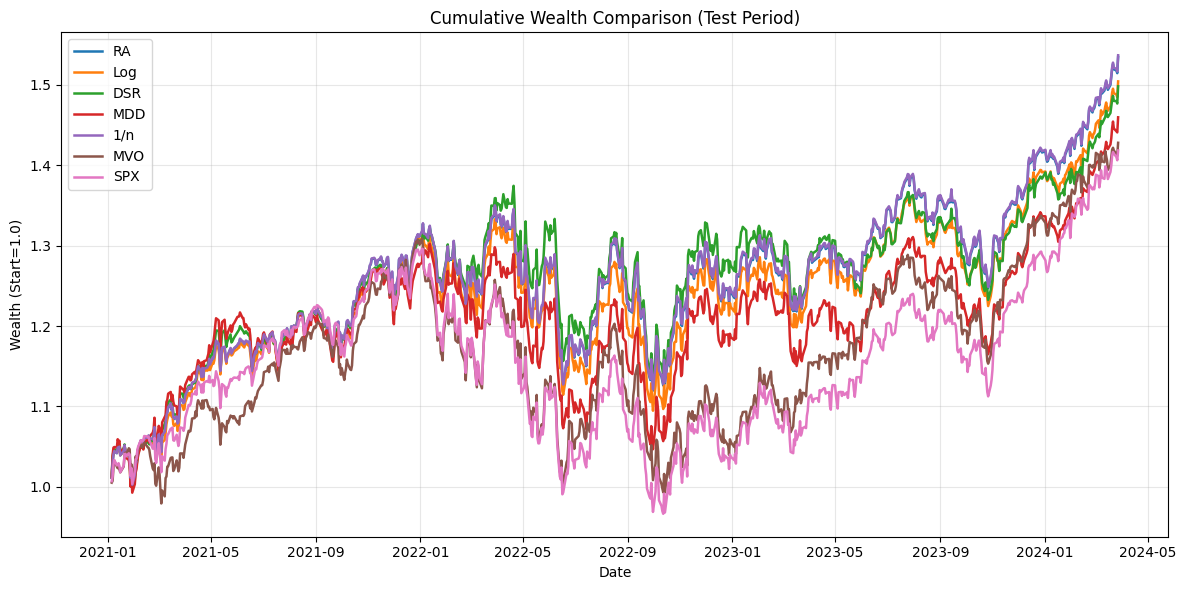

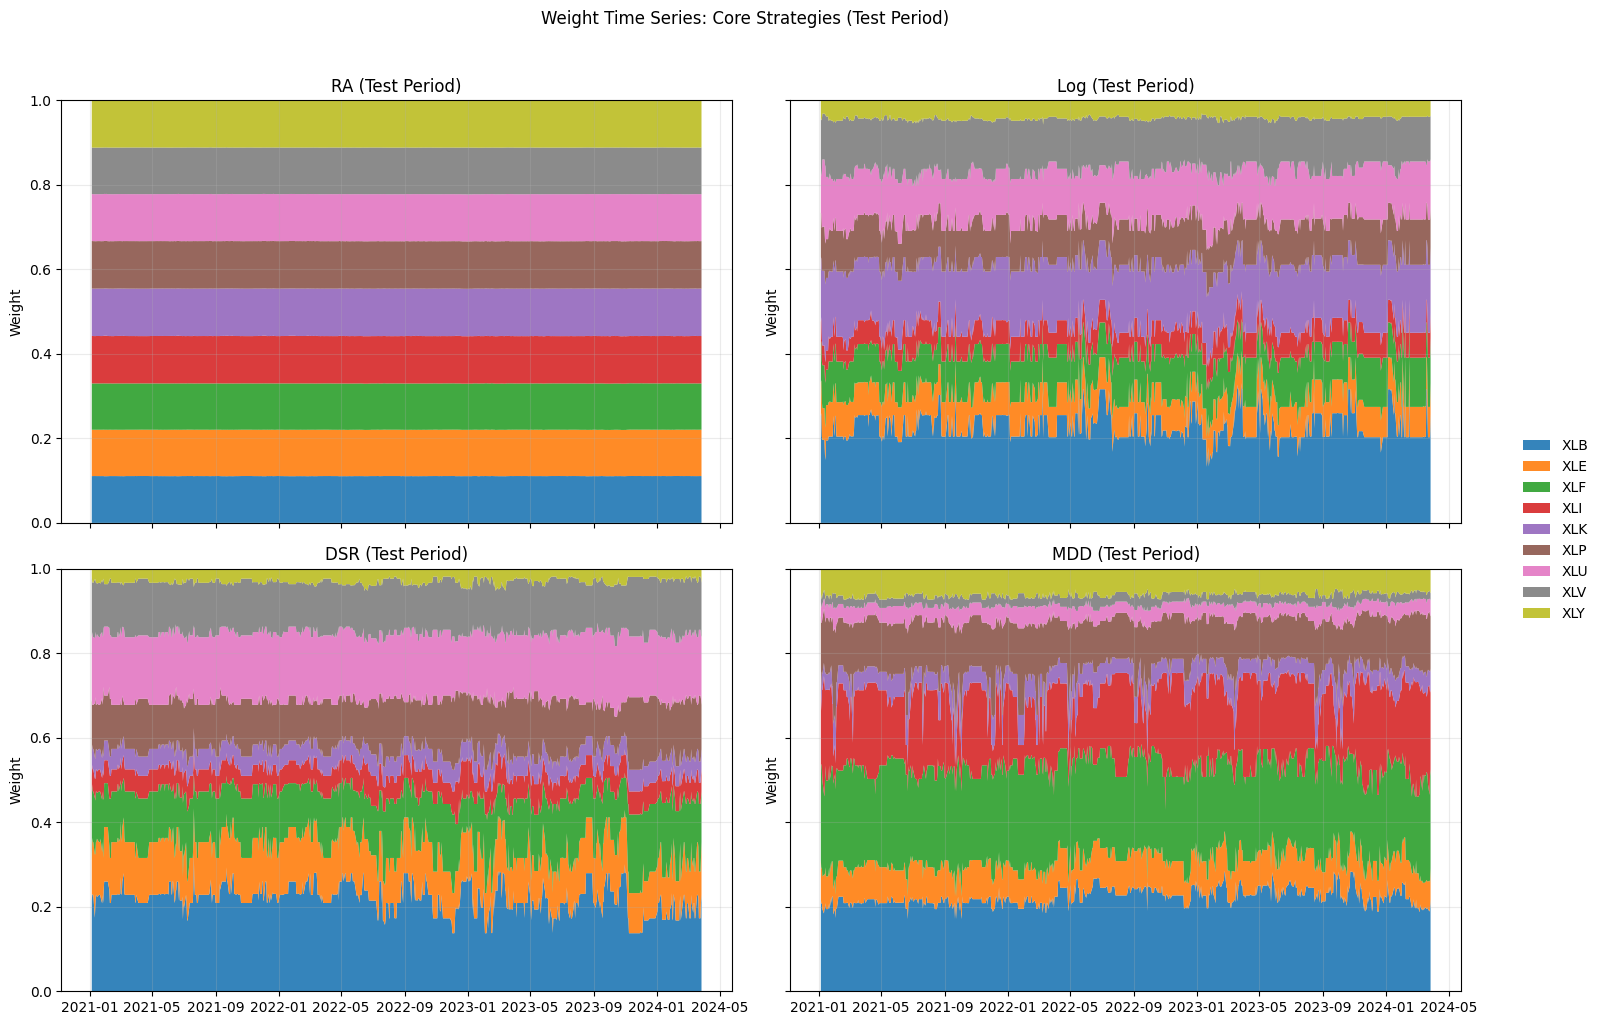

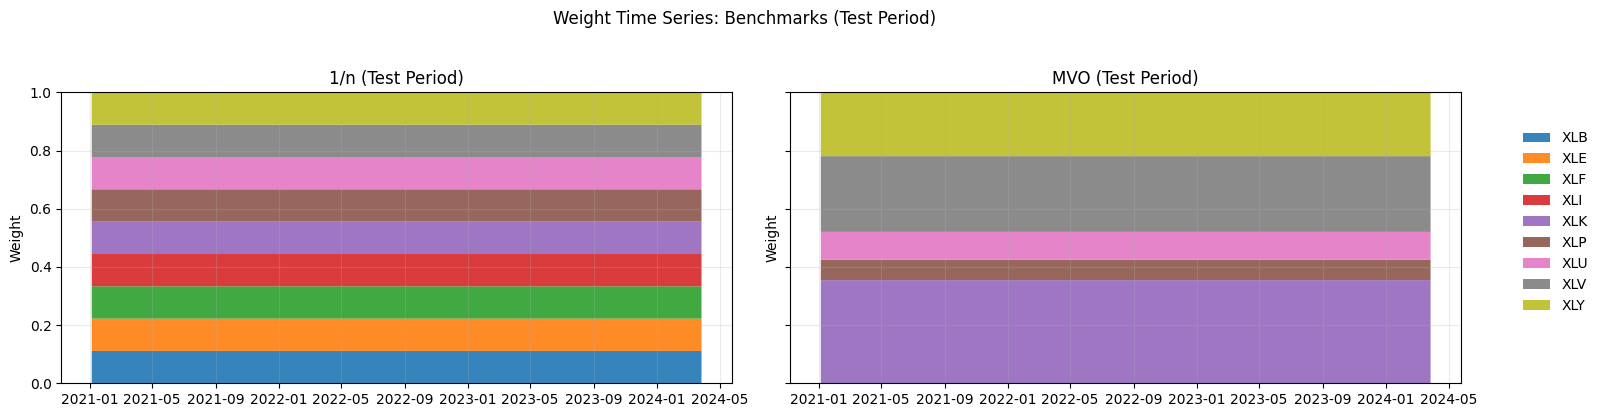

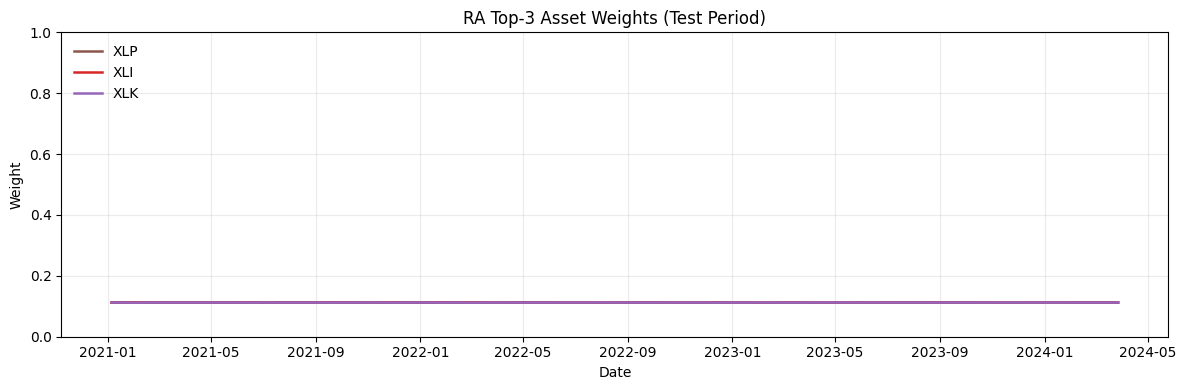

,CR,AR,SR,CAR,SOR,OR,AV,Stability
1/n,0.536639,0.142619,0.942019,0.841810,1.331467,1.172557,0.154176,0.657233
RA,0.534566,0.142141,0.939423,0.837644,1.326898,1.172085,0.154152,0.654113
DSR,0.498084,0.133644,0.909612,0.758200,1.296542,1.164908,0.150352,0.611889
Log,0.504144,0.135065,0.897088,0.756447,1.276871,1.163800,0.154561,0.598449
MDD,0.459501,0.124501,0.800357,0.635093,1.143006,1.141774,0.163284,0.361966
MVO,0.427825,0.116870,0.723034,0.484634,0.973714,1.130074,0.173779,0.323647
SPX,0.418262,0.114543,0.716648,0.450511,0.955469,1.129623,0.171984,0.111004


In [21]:
# Visualization
# Figure A: cumulative wealth
cum_wealth = (1.0 + strategy_returns_df).cumprod()

plt.figure(figsize=(12, 6))
for col in cum_wealth.columns:
    plt.plot(cum_wealth.index, cum_wealth[col], label=col, linewidth=1.8)
plt.title('Cumulative Wealth Comparison (Test Period)')
plt.xlabel('Date')
plt.ylabel('Wealth (Start=1.0)')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Figure B: weight area charts for RA/Log/DSR/MDD
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
main_strategies = ['RA', 'Log', 'DSR', 'MDD']
for ax, name in zip(axes.ravel(), main_strategies):
    plot_weight_area(ax, weight_views_plot[name], name, asset_color_map)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
fig.suptitle('Weight Time Series: Core Strategies (Test Period)', y=1.02)
fig.tight_layout()
plt.show()

# Figure C: weight area charts for 1/n and MVO
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
for ax, name in zip(axes, ['1/n', 'MVO']):
    plot_weight_area(ax, weight_views_plot[name], name, asset_color_map)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
fig.suptitle('Weight Time Series: Benchmarks (Test Period)', y=1.03)
fig.tight_layout()
plt.show()

# Figure D: top-3 RA assets
fig, ax = plt.subplots(figsize=(12, 4))
plot_ra_top_assets(ax, weight_views_plot['RA'], top_k=3, color_map=asset_color_map)
ax.set_xlabel('Date')
fig.tight_layout()
plt.show()

# Figure E (optional): RA gate alpha time series
if ra_alpha_plot_view is not None and len(ra_alpha_plot_view) > 0:
    fig, ax = plt.subplots(figsize=(12, 4))
    for col in ra_alpha_plot_view.columns:
        ax.plot(ra_alpha_plot_view.index, ra_alpha_plot_view[col], linewidth=1.6, label=col)
    ax.set_ylim(0.0, 1.0)
    ax.set_title('RA Gate Alpha Time Series (Test Period)')
    ax.set_ylabel('Alpha')
    ax.set_xlabel('Date')
    ax.grid(alpha=0.25)
    ax.legend(loc='upper left', frameon=False)
    fig.tight_layout()
    plt.show()

metrics_df.sort_values('SR', ascending=False)


## Results and Notes

- `metrics_df` で7戦略（RA, Log, DSR, MDD, 1/n, MVO, SPX）の同一期間比較を実施。
- 取引コストは全戦略で `0.05%` を適用（SPXは単純日次変化率、取引コストなし）。
- 行動制約は全戦略で `sum(w)=1` と `w>=0` を満たす実装。
- SPXは単一指数ベンチマークのため、ウェイト時系列可視化の対象外。
- `c_selection_report` と `Selected c_value` 出力で、教師ターゲットのスケーリング選択を確認可能。
- `weight_diagnostics_df` と `RA update guard` 出力で、RA更新性（turnover等）を確認可能。
- `fallback_triggered=True` の場合、RAは rolling Sharpe に基づく動的凸結合へ自動フォールバック。
- RA上位3資産の折れ線により、配分集中とローテーションの時系列変化を確認可能。
- ウェイト時系列（積み上げ面積）で、RA/Log/DSR/MDD と 1/n/MVO の配分推移を比較可能。

### Failure modes observed in this approximation
- 擬似価格由来のテクニカル指標は、実OHLCベース指標と分布が異なる可能性がある。
- DSRは標準式採用のため、論文本文の記号曖昧部と完全一致しない可能性がある。
- CPU実行かつ単一データセットのため、論文の規模/市場多様性とは差がある。


## Next Steps

- 厳密再現への移行ポイント:
  1. 4市場30銘柄OHLCの取得とユニバース再定義。
  2. 実OHLCでSMA/MACD/BB/RSI/CCI/ADXを再計算。
  3. DSR式を原本数式の目視確認により最終固定。
  4. 論文設定に近い timesteps / episodes で再学習。
